# ========================================
# GEMSTONES CNN CLASSIFICATION - VERSION AMÉLIORÉE
# Dataset: https://www.kaggle.com/datasets/lsind18/gemstones-images/data
# Objectif: Accuracy > 85% avec Transfer Learning + Optimisations
# ========================================

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, applications, optimizers, callbacks
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import warnings
warnings.filterwarnings("ignore")

# 1. CONFIGURATION GÉNÉRALE

In [2]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 87
EPOCHS_INITIAL = 50
EPOCHS_FINE_TUNE = 30
SEED = 42

# Chemins du dataset (à adapter selon votre structure)
TRAIN_DIR = "gemstones/train"
TEST_DIR = "gemstones/test"
MODEL_SAVE_PATH = "models/gemstones_cnn_efficientnet.keras"

os.makedirs("models", exist_ok=True)

# 2. CHARGEMENT ET AUGMENTATION DES DONNÉES


In [3]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
], name="data_augmentation")

# Chargement des datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=SEED,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = train_dataset.class_names
print(f"Classes détectées ({len(class_names)}): {class_names[:5]}...")

# Appliquer l'augmentation uniquement au train
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Préfetch pour performance
train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

Found 2856 files belonging to 87 classes.
Found 363 files belonging to 87 classes.
Classes détectées (87): ['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst']...


# 3. VISUALISATION D'EXEMPLES

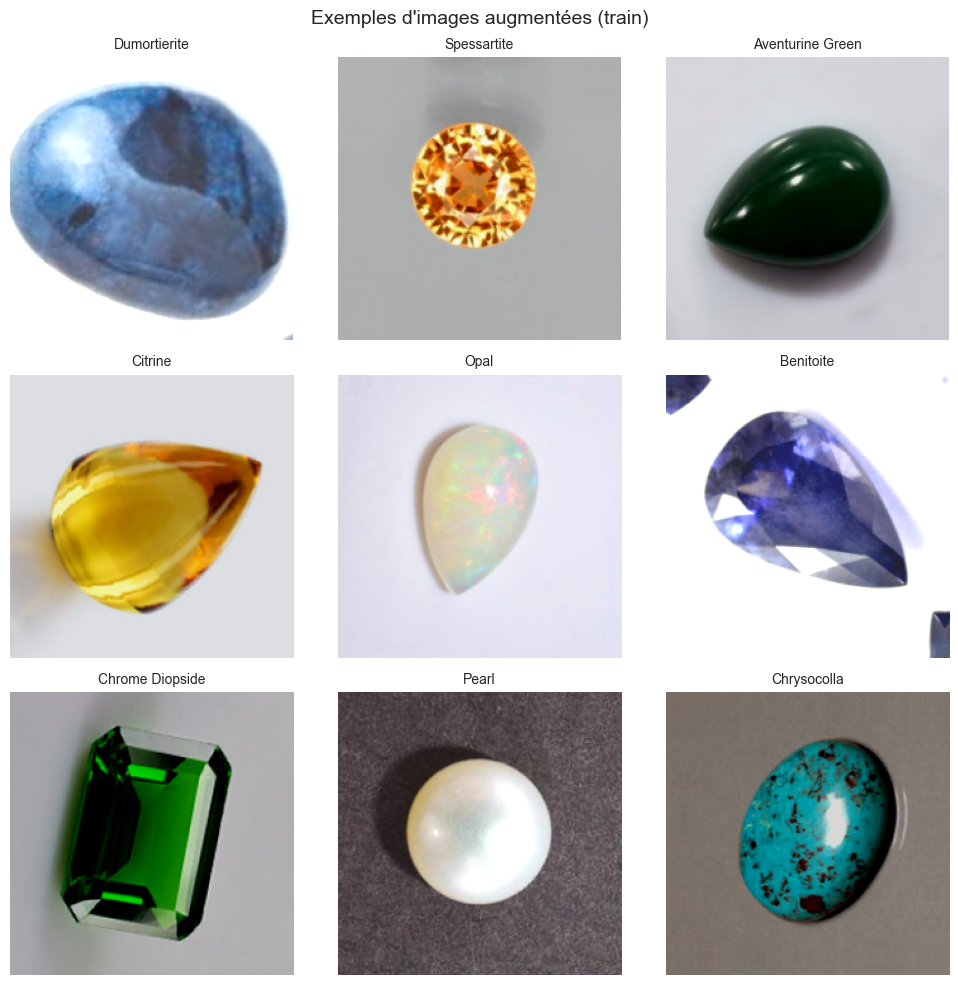

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis("off")
plt.suptitle("Exemples d'images augmentées (train)", fontsize=14)
plt.tight_layout()
plt.show()

# 4. CONSTRUCTION DU MODÈLE (EfficientNetB0 + Transfer Learning)

In [5]:
base_model = applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Congeler le backbone initialement
base_model.trainable = False

model = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Lambda(lambda x: tf.keras.applications.efficientnet.preprocess_input(x)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
], name="Gemstone_EfficientNetB0")

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



Model: "Gemstone_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 87)             │        22,359 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,864,250 (18.56 MB)

 Trainable params: 812,119 (3.10 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

# 5. COMPILATION & CALLBACKS

In [6]:
initial_optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=initial_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH, save_best_only=True, monitor='val_accuracy', verbose=1
)

# 6. ENTRAÎNEMENT INITIAL (couches supérieures)

In [ ]:
print("\n" + "="*50)
print("PHASE 1 : Entraînement des couches supérieures")
print("="*50)

history_initial = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS_INITIAL,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


PHASE 1 : Entraînement des couches supérieures
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.0752 - loss: 5.5777
Epoch 1: val_accuracy improved from None to 0.36639, saving model to models/gemstones_cnn_efficientnet.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 782ms/step - accuracy: 0.1254 - loss: 5.0691 - val_accuracy: 0.3664 - val_loss: 4.3691 - learning_rate: 0.0010
Epoch 2/50
14/90 ━━━━━━━━━━━━━━━━━━━━ 44s 579ms/step - accuracy: 0.3502 - loss: 3.6844

# 7. FINE-TUNING (décongeler les dernières couches)

In [ ]:
print("\n" + "="*50)
print("PHASE 2 : Fine-tuning des dernières couches du backbone")
print("="*50)

# Décongeler les 50 dernières couches
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompiler avec un LR plus petit
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# 8. ÉVALUATION FINALE

In [ ]:
print("\n" + "="*50)
print("ÉVALUATION FINALE")
print("="*50)

test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

# Prédictions détaillées
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_proba.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Rapport de classification
print("\n--- Rapport de Classification ---")
report = classification_report(y_true, y_pred, target_names=class_names, digits=3, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# F1-score moyen
f1_macro = report['macro avg']['f1-score']
print(f"\nF1-Score Macro: {f1_macro:.3f}")


# 9. VISUALISATION DES (Courbes + Matrice de confusion)

In [ ]:
# Courbes d'entraînement
def plot_history(hist1, hist2, title_suffix=""):
    acc = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    loss = hist1.history['loss'] + hist2.history['loss']
    val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_initial, history_fine, "(EfficientNetB0)")

# Matrice de confusion (échantillonnée si trop grande)
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion - Gemstones Classification')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 10. SAUVEGARDE FINALE

In [ ]:
final_model_path = "models/gemstones_cnn_final_efficientnet.keras"
model.save(final_model_path)
print(f"\nModèle final sauvegardé : {final_model_path}")
print(f"Meilleure accuracy de validation atteinte : {max(history_initial.history['val_accuracy'] + history_fine.history['val_accuracy']):.4f}")

# RÉSUMÉ DES PERFORMANCES

In [ ]:
print("\n" + "="*60)
print("RÉSUMÉ FINAL")
print("="*60)
print(f"Dataset: {len(os.listdir(TRAIN_DIR))} classes | {sum(len(files) for _, _, files in os.walk(TRAIN_DIR))} images d'entraînement")
print(f"Test: {len(y_true)} images")
print(f"Modèle: EfficientNetB0 + Transfer Learning + Data Augmentation")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"F1-Score Macro: {f1_macro:.3f}")
print(f"Modèle sauvegardé: {final_model_path}")
print("="*60)